In [2]:
import torch
import torch.nn
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import CelebA
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
#print("GUP name:", torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Deice is:', device, '\n')
#print('Total number of GPUs:', torch.cuda.device_count())

Deice is: cpu 



In [4]:
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

faces = fetch_olivetti_faces()
images = faces.images  # Shape: (400, 64, 64)
labels = faces.target  # Shape: (400,)
print("Olivetti faces images shape:", faces.images.shape)

#images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # New shape: (400, 1, 64, 64)
#labels_tensor = torch.tensor(labels, dtype=torch.long)
#
#dataset = TensorDataset(images_tensor, labels_tensor)
#dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

Olivetti faces images shape: (400, 64, 64)


In [5]:
#batch_images, batch_labels = next(iter(dataloader))
#fig, ax = plt.subplots(1, 5, figsize=(10, 3))
#for i, (img, lab) in enumerate(zip(batch_images[:5], batch_labels[:5])):
#    ax[i].imshow(img.squeeze(0), cmap='gray')
#    ax[i].set_title(lab.item())
#
#plt.show()

In [6]:
from diffusers import DDPMScheduler
from PIL import Image
import numpy as np

# Hyperparameter: number of steps to turn clear image to noise
max_timesteps = 39

# Initialize DDPM Scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=max_timesteps,
                                beta_start=0.0001,
                                beta_end=0.02)

def plot_images(timesteps, noisy_images):
  fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 15))
  for i, t in enumerate(timesteps):
    img = noisy_images[i].permute(1, 2, 0).numpy()  # Convert to HWC format
    img = np.clip(img, 0, 1)  # Ensure the values are in [0, 1]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f't = {t}')
    axes[i].axis('off')
  plt.savefig('imgx.png')
  plt.show()

def get_img_subregion(img, x, y, w, h):
  return img[:, y:y+h, x:x+w]

def get_corruption_region(img, w=20, h=20):
  _, H, W = img.shape
  x = torch.randint(0, W - w + 1, (1,))
  y = torch.randint(0, H - h + 1, (1,))
  return x, y, w, h

/usr/local/Caskroom/miniforge/base/envs/5527/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import fiftyone
dataset = fiftyone.zoo.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections", "segmentations"],
    classes=["person", "car"],
    max_samples=500,
)

dataset.export(
    export_dir="coco_subset_export",
    dataset_type=fiftyone.types.COCODetectionDataset,
    label_field="detections",
)


Found annotations at '/Users/rvolkov/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-500'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Directory 'coco_subset_export' already exists; export will be merged with existing files
 100% |█████████████████| 500/500 [1.2m elapsed, 0s remaining, 5.3 samples/s]       


In [8]:
root = "coco_subset_export/data"
annFile = "coco_subset_export/labels.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.CocoDetection(root=root, annFile=annFile, transform=transform)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [9]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [10]:
import torchvision
from PIL import Image
import torchvision.transforms as T
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

def get_pred(img):
  model.eval()

  with torch.no_grad():
    prediction = model([torch.Tensor(img).to(device)])

  pred = prediction[0]

  labels = pred['labels'].tolist()
  label_names = [COCO_INSTANCE_CATEGORY_NAMES[i] if i < len(COCO_INSTANCE_CATEGORY_NAMES) else COCO_INSTANCE_CATEGORY_NAMES[0] for i in labels]

  #print(pred["boxes"][0])
  #print(COCO_INSTANCE_CATEGORY_NAMES[pred["labels"][0]])

  return pred["boxes"], label_names


/usr/local/Caskroom/miniforge/base/envs/5527/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/5527/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
import pandas as pd
from tqdm import tqdm
from pycocotools.coco import COCO

# Load COCO annotations to get proper mapping

preds = []

#for i in tqdm(range(new_ds_imgs.shape[0])):
for i, (batch_images, batch_labels) in tqdm(enumerate(iter(dataloader))):
  bboxes, classes = get_pred(batch_images[0])
  preds.append({
      'image_idx': i,
      'classes': classes,
      'bboxes': bboxes
  })

  if (i == 5):
    break

df = pd.DataFrame(preds)


5it [00:14,  2.98s/it]


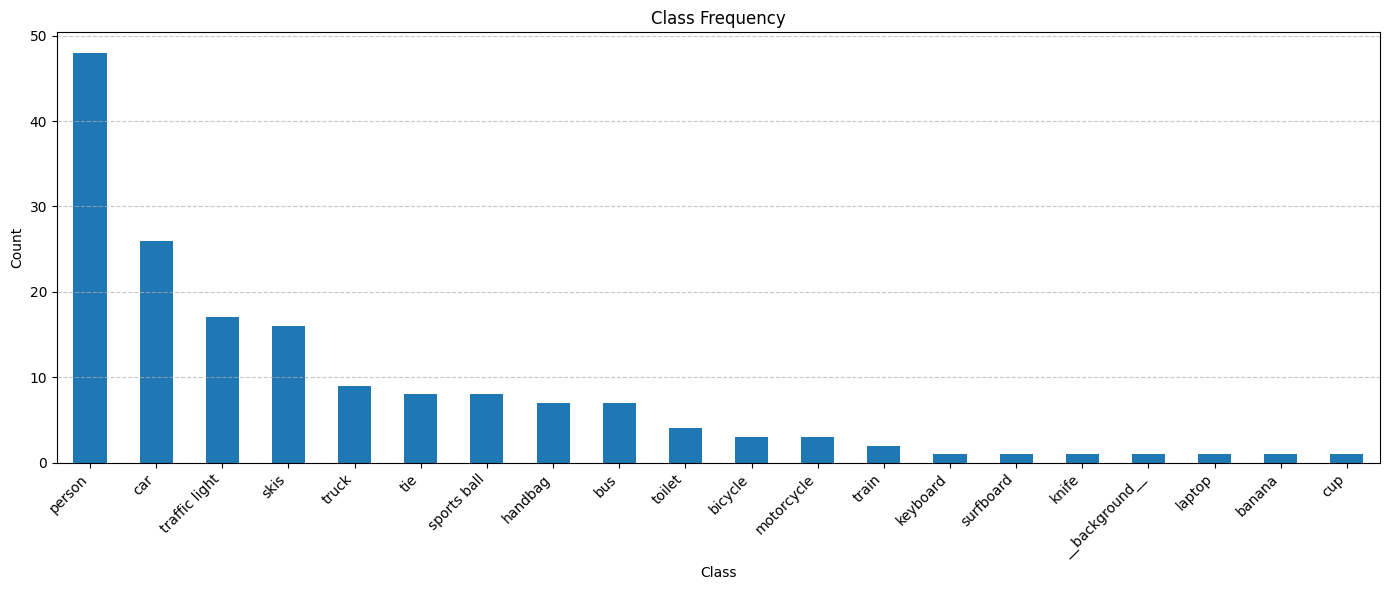

In [56]:
from collections import Counter

all_classes = [cls for sublist in df['classes'] for cls in sublist]
class_counts = pd.Series(Counter(all_classes)).sort_values(ascending=False)

plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar')
plt.title("Class Frequency")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("hist.png")
plt.show()

In [52]:
new_dataset_images = []
new_dataset_labels = []

for i, item in enumerate(iter(dataset)):
  if (i >= len(df)):
    break

  print(item[0].shape)
  print(item[1][0]["bbox"])

  image = item[0].numpy()
  img_shape = image.shape

  print("img_shape:", img_shape)

  print(batch_labels)

  #x, y, w, h = get_corruption_region(image)

  bboxes = item[1][0]["bbox"]
  x1, y1, w, h = bboxes

  label_name = item[1][0]["image_id"]
  new_dataset_labels.append(COCO_INSTANCE_CATEGORY_NAMES[label_name])

  #plt.imshow(torchvision.transforms.functional.to_pil_image(image))
  plt.imshow(np.transpose(image, (1, 2, 0)))
  plt.axis('off')
  plt.title("Sample Image")
  plt.show()

  x = int(x1)
  y = int(y1)
  w = int(w)
  h = int(h)

  print(x, y, w, h)

  sub_img = torch.Tensor(get_img_subregion(image, x, y, w, h))
  sub_img_shape = sub_img.shape

  jumps = 8
  timesteps = torch.arange(0, max_timesteps, jumps)  # [1, 2, 3, .... 10]
  noise = torch.randn(sub_img_shape)  # Generate random noise
  # Add noise to images
  noisy_images = []
  for t in timesteps:
    noisy_image = noise_scheduler.add_noise(sub_img, noise, t)
    img_curr = torch.Tensor(image)
    img_curr[:, y:y+h, x:x+w] = noisy_image
    noisy_images.append(img_curr)
  # Plot
  #plot_images(timesteps, noisy_images)
  new_dataset_images.append(noisy_images[-1])

new_ds_imgs = torch.stack(new_dataset_images)
new_ds_imgs.shape

ValueError: Index must be of type integer, got <class 'slice'> instead.

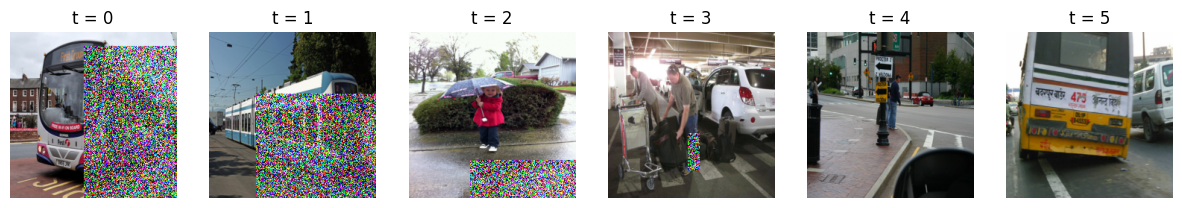

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus']


In [53]:
plot_images(np.arange(len(new_dataset_images)), new_dataset_images)
print(new_dataset_labels)